<a href="https://colab.research.google.com/github/mariamhergnyan/Molecular_Simulations_exam/blob/main/Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Run these before working.

In [1]:
!pip install notebook==6.5.5  > /dev/null

In [2]:
!pip install ipywidgets > /dev/null

In [3]:
!pip install pyemma > /dev/null
!pip install mdshare > /dev/null
#4 minutes

In [4]:
!pip install nglview > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires notebook==6.5.5, but you have notebook 7.0.8 which is incompatible.


In [5]:
!pip install biopython > /dev/null

In [6]:
from google.colab import output
output.enable_custom_widget_manager()

Support for third party widgets will remain active for the duration of the session. To disable support:

In [7]:
%matplotlib inline
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
import mdshare
import pyemma
# for visualization of molecular structures:
import nglview
import mdtraj
from threading import Timer
from nglview.player import TrajectoryPlayer
from Bio.PDB import PDBParser
import pyemma.util.contexts as contexts

from IPython.display import display
from threading import Timer
from google.colab import widgets
import ipywidgets
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [8]:
#mdshare.fetch is used for fetching from their server.
#In my case I have it locally, so it just should be the path

In [9]:
pdb = '/content/lb6-filtered.pdb'
#traj
#files = '/content/lb6-filtered.xtc'
folder_path = '/content/New_timestamped'

files_and_dirs = os.listdir(folder_path)

#Remove the checkpoint directory if it exists
for item in files_and_dirs:
    if item == '.ipynb_checkpoints':
        checkpoint_path = os.path.join(folder_path, item)
        shutil.rmtree(checkpoint_path)

files = os.listdir(folder_path)
#final paths to the files
files = [os.path.join(folder_path, file) for file in os.listdir(folder_path)]

In [10]:
files

['/content/New_timestamped/10_strd.lammpstrj',
 '/content/New_timestamped/15_strd.lammpstrj']

#Feature selection
Since we don't know which features describe the best the molecule, we do feature selecting with VAMP(Variational Approach for Markov Proceess). We utilize the VAMP2 score which shows the kinetic variance. The minimum VAMP2 score is 1. The higher the score, the better the given feature describes the molecule. Here we only do the selection based on the features of the backbone and not the side chains.

In [11]:
torsions_feat = pyemma.coordinates.featurizer(pdb)
torsions_feat.add_backbone_torsions(cossin=True, periodic=False)
torsions_data = pyemma.coordinates.load(files, features=torsions_feat)
labels = ['backbone\ntorsions']

positions_feat = pyemma.coordinates.featurizer(pdb)
positions_feat.add_selection(positions_feat.select_Backbone())
positions_data = pyemma.coordinates.load(files, features=positions_feat)
labels += ['backbone atom\npositions']

distances_feat = pyemma.coordinates.featurizer(pdb)
distances_feat.add_distances(
    distances_feat.pairs(distances_feat.select_Backbone(), excluded_neighbors=2), periodic=False)
distances_data = pyemma.coordinates.load(files, features=distances_feat)
labels += ['backbone atom\ndistances']

In [12]:
def score_cv(data, dim, lag, number_of_splits=10, validation_fraction=0.5):
#compute a cross validated vamp 2 score
    # we temporarily suppress very short-lived progress bars
    with contexts.settings(show_progress_bars=False):
        nval = int(len(data) * validation_fraction)
        scores = np.zeros(number_of_splits)
        for n in range(number_of_splits):
            ival = np.random.choice(len(data), size=nval, replace=False)
            vamp = pyemma.coordinates.vamp(
                [d for i, d in enumerate(data) if i not in ival], lag=lag, dim=dim)
            scores[n] = vamp.score([d for i, d in enumerate(data) if i in ival])
    return scores

def find_max_vamp_score(data_sets, labels, dims, lags):
    max_score = -float('inf')
    best_property = None
    best_lag = None

    for property_data, property_label in zip(data_sets, labels):
        for lag in lags:
            scores = score_cv(property_data, lag=lag, dim=dims[property_label])
            mean_score = scores.mean()
            if mean_score > max_score:
                max_score = mean_score
                best_property = property_label
                best_lag = lag

    return best_property, best_lag, max_score

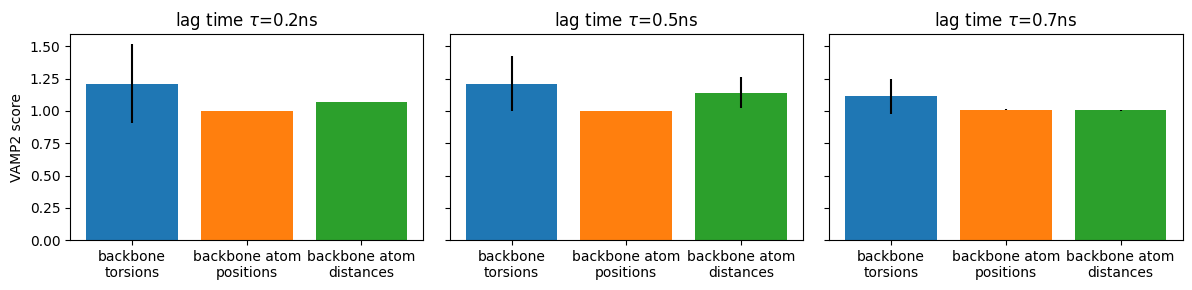

In [13]:
dim = 1

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
for ax, lag in zip(axes.flat, [2, 5, 7]):
    torsions_scores = score_cv(torsions_data, lag=lag, dim=dim)
    scores = [torsions_scores.mean()]
    errors = [torsions_scores.std()]
    positions_scores = score_cv(positions_data, lag=lag, dim=dim)
    scores += [positions_scores.mean()]
    errors += [positions_scores.std()]
    distances_scores = score_cv(distances_data, lag=lag, dim=dim)
    scores += [distances_scores.mean()]
    errors += [distances_scores.std()]
    ax.bar(labels, scores, yerr=errors, color=['C0', 'C1', 'C2'])
    ax.set_title(r'lag time $\tau$={:.1f}ns'.format(lag * 0.1))
    if lag == 5:
        # save for later
        vamp_bars_plot = dict(
            labels=labels, scores=scores, errors=errors, dim=dim, lag=lag)
axes[0].set_ylabel('VAMP2 score')
fig.tight_layout()

Trying with different lag times and dimensions

In [14]:
dims = {'backbone torsions': 10, 'backbone atom positions': 10, 'backbone atom distances': 10}
labels_prime = ['backbone torsions', 'backbone atom positions', 'backbone atom distances']
lags = [2,5,7]
best_property, best_lag, max_score = find_max_vamp_score(
    [torsions_data, positions_data, distances_data],
    labels_prime,
    dims,
    lags
)

print("Property that descrbes the data best:", best_property)
print("Lag time of the highest score:", best_lag)
print("Highest VAMP2 score:", max_score)

# Determine the dataset based on the best property label
if best_property == 'backbone torsions':
  data = torsions_data
elif best_property == 'backbone atom positions':
  data = positions_data
elif best_property == 'backbone atom distances':
  data = distances_data
else:
  raise ValueError("Unknown property label: {}".format(best_property))


Property that descrbes the data best: backbone torsions
Lag time of the highest score: 5
Highest VAMP2 score: 3.5829224901214487


Computing VAMP score for dim=1, lag=1
Computing VAMP score for dim=2, lag=1
Computing VAMP score for dim=3, lag=1
Computing VAMP score for dim=4, lag=1
Computing VAMP score for dim=5, lag=1
Computing VAMP score for dim=6, lag=1
Computing VAMP score for dim=7, lag=1
Computing VAMP score for dim=8, lag=1
Computing VAMP score for dim=9, lag=1
Computing VAMP score for dim=10, lag=1
Computing VAMP score for dim=1, lag=2
Computing VAMP score for dim=2, lag=2
Computing VAMP score for dim=3, lag=2
Computing VAMP score for dim=4, lag=2
Computing VAMP score for dim=5, lag=2
Computing VAMP score for dim=6, lag=2
Computing VAMP score for dim=7, lag=2
Computing VAMP score for dim=8, lag=2
Computing VAMP score for dim=9, lag=2
Computing VAMP score for dim=10, lag=2
Computing VAMP score for dim=1, lag=5
Computing VAMP score for dim=2, lag=5
Computing VAMP score for dim=3, lag=5
Computing VAMP score for dim=4, lag=5
Computing VAMP score for dim=5, lag=5
Computing VAMP score for dim=6, lag=5
Computing 

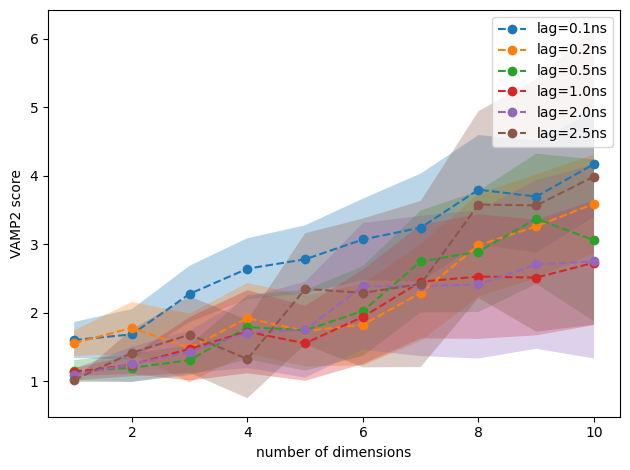

In [27]:
lags = [1,2,5,10,20,25]
#dims = [1] #rn only for 1 dimension until I get the timestamped frames of trajectory, just fine the best lag time
dims = [i + 1 for i in range(10)]

fig, ax = plt.subplots()
for i, lag in enumerate(lags):
    scores_ = []
    for dim in dims:
        print("Computing VAMP score for dim={}, lag={}".format(dim, lag))
        score = score_cv(data, dim, lag)
        scores_.append(score)
    scores_ = np.array(scores_)

    scores = np.mean(scores_, axis=1)
    errors = np.std(scores_, axis=1, ddof=1)
    color = 'C{}'.format(i)
    ax.fill_between(dims, scores - errors, scores + errors, alpha=0.3, facecolor=color)
    ax.plot(dims, scores, '--o', color=color, label='lag={:.1f}ns'.format(lag * 0.1))
ax.legend()
ax.set_xlabel('number of dimensions')
ax.set_ylabel('VAMP2 score')
fig.tight_layout()


In [16]:
tica = pyemma.coordinates.tica(data, lag=best_lag)
tica_output = tica.get_output()
tica_concatenated = np.concatenate(tica_output)
len(tica_concatenated)

1134

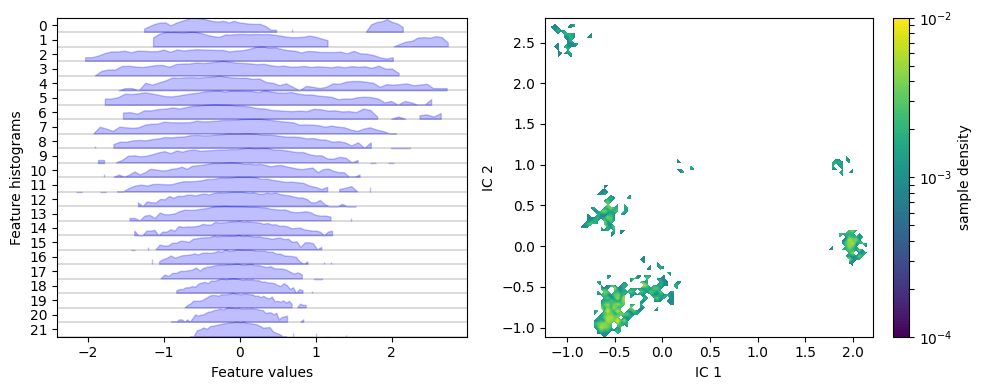

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(
    tica_concatenated,
    ax=axes[0],
    #feature_labels=['IC1', 'IC2'], #fix this
    ylog=True)
pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], logscale=True)
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
fig.tight_layout()


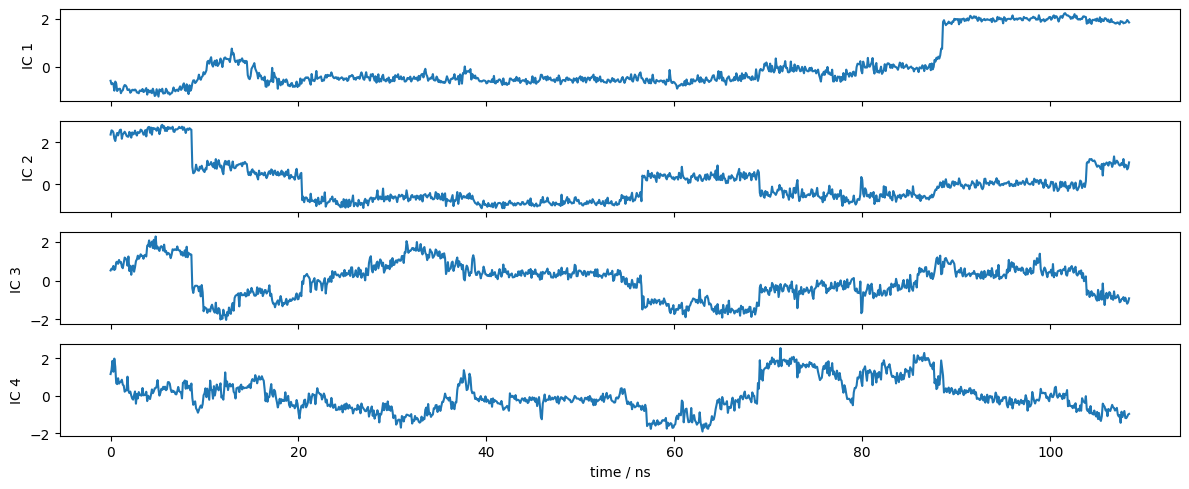

In [18]:
fig, axes = plt.subplots(4, 1, figsize=(12, 5), sharex=True)
x = 0.1 * np.arange(tica_output[0].shape[0])
for i, (ax, tic) in enumerate(zip(axes.flat, tica_output[0].T)):
    ax.plot(x, tic)
    ax.set_ylabel('IC {}'.format(i + 1))
axes[-1].set_xlabel('time / ns')
fig.tight_layout()

In [19]:
feat = pyemma.coordinates.featurizer(pdb)
feat.add_backbone_torsions(periodic=False)
data = pyemma.coordinates.load(files, features=feat)
print("data len:",len(data))
print("data shape:",np.shape(data))
data_concatenated = np.concatenate(data)
print("data_concat len:",len(data_concatenated))
print("data_concat shape:", np.shape(data_concatenated))
# Check the number of dimensions in the data
num_dimensions = data_concatenated.shape[1]
print("num dimensions",num_dimensions)

# Define feature labels corresponding to each dimension
feature_labels = ['$\Phi$', '$\Psi$'] * (num_dimensions // 2)


# Ensure that the length of feature_labels matches the number of dimensions
if len(feature_labels) != num_dimensions:
    # Adjust the feature labels to match the number of dimensions
    feature_labels = ['$\Phi$', '$\Psi$'] * num_dimensions
print("Len feature labels", len(feature_labels))


data len: 2
data shape: (2,)
data_concat len: 1134
data_concat shape: (1134, 24)
num dimensions 24
Len feature labels 24


initialize kmeans++ centers:   0%|          | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|          | 0/50 [00:00<?, ?it/s]

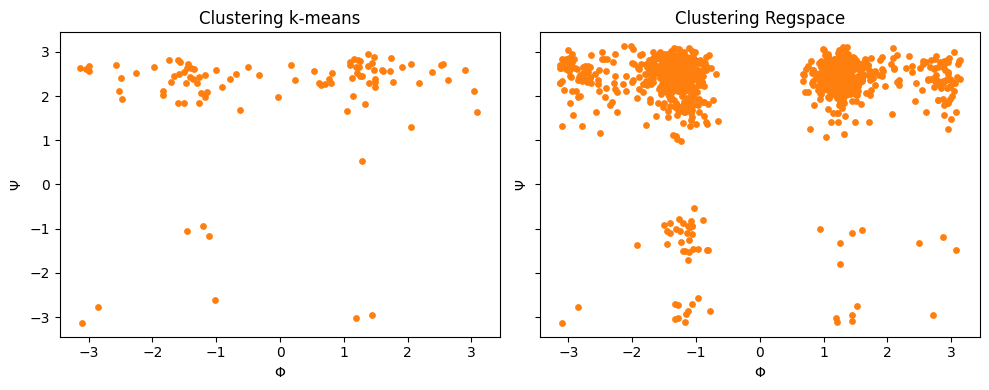

In [20]:
cluster_kmeans = pyemma.coordinates.cluster_kmeans(data, k=100, max_iter=50, stride=5)
cluster_regspace = pyemma.coordinates.cluster_regspace(data, dmin=0.3)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
for ax, cls, title in zip(axes.flat, [cluster_kmeans, cluster_regspace], ["Clustering k-means", "Clustering Regspace"]):
    pyemma.plots.plot_density(cls.clustercenters[:, 0], cls.clustercenters[:, 1], ax=ax, cbar=False, alpha=0.1, logscale=True)
    ax.scatter(cls.clustercenters[:, 0], cls.clustercenters[:, 1], s=15, c='C1')
    ax.set_xlabel('$\Phi$')
    ax.set_ylabel('$\Psi$')
    ax.set_title(title)
fig.tight_layout()


estimating BayesianMSM:   0%|          | 0/6 [00:00<?, ?it/s]

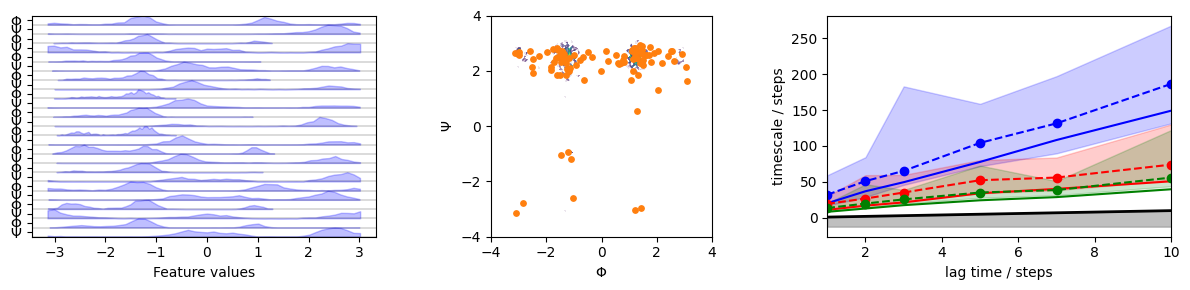

In [28]:
cluster = cluster_kmeans
its = pyemma.msm.its(
    cluster.dtrajs, lags=[1, 2, 3, 5, 7, 10], nits=3, errors='bayes')

# Plot feature histograms
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pyemma.plots.plot_feature_histograms(data_concatenated, feature_labels=feature_labels, ax=axes[0])
pyemma.plots.plot_density(data_concatenated[:, 0], data_concatenated[:, 1], ax=axes[1], cbar=False, alpha=0.1)
axes[1].scatter(cluster.clustercenters[:, 0], cluster.clustercenters[:, 1], s=15, c='C1')
axes[1].set_xlabel('$\Phi$')
axes[1].set_ylabel('$\Psi$')
axes[1].set_xlim(-4, 4)
axes[1].set_ylim(-4, 4)
axes[1].set_aspect('equal')
pyemma.plots.plot_implied_timescales(its, ylog=False, ax=axes[2])
fig.tight_layout()


Regspace seems to make better clusters. But the kmeans lag times look better. Maybe another clustering algorithm should be implemented

This part is just for testing

In [22]:
pdb_1= mdshare.fetch('pentapeptide-impl-solv.pdb', working_directory='data')
files_1 = mdshare.fetch('pentapeptide-*-500ns-impl-solv.xtc', working_directory='data')

#files_1 = ['lb6-filtered_01.lammpstrj','lb6-filtered_02.lammpstrj','lb6-filtered_12.lammpstrj']
torsions_feat_1 = pyemma.coordinates.featurizer(pdb_1)
torsions_feat_1.add_backbone_torsions(cossin=True, periodic=False)
torsions_data_1 = pyemma.coordinates.load(files_1, features=torsions_feat_1)
labels_1 = ['backbone\ntorsions']

positions_feat_1 = pyemma.coordinates.featurizer(pdb_1)
positions_feat_1.add_selection(positions_feat_1.select_Backbone())
positions_data_1 = pyemma.coordinates.load(files_1, features=positions_feat_1)
labels_1 += ['backbone atom\npositions']

distances_feat_1 = pyemma.coordinates.featurizer(pdb_1)
distances_feat_1.add_distances(
    distances_feat_1.pairs(distances_feat_1.select_Backbone(), excluded_neighbors=2), periodic=False)
distances_data_1 = pyemma.coordinates.load(files_1, features=distances_feat_1)
labels_1 += ['backbone atom\ndistances']

Obtaining file info:   0%|          | 0/25 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/25 [00:00<?, ?it/s]

Obtaining file info:   0%|          | 0/25 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/25 [00:00<?, ?it/s]

Obtaining file info:   0%|          | 0/25 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/25 [00:00<?, ?it/s]

In [23]:
files_1[0]
files_1[2]

'data/pentapeptide-02-500ns-impl-solv.xtc'

In [24]:
def compare_files(file1, file2):
    with open(file1, 'r') as f1, open(file2, 'r') as f2:
        # Read the contents of the files
        content1 = f1.read()
        content2 = f2.read()

        # Compare the contents
        if content1 == content2:
            print("The contents of the files are the same.")
        else:
            print("The contents of the files are different.")

# Specify the paths to the lammpstrj files
file1_path = files_1[0]
file2_path = files_1[2]

# Call the function to compare the files
compare_files(file1_path, file2_path)


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xcb in position 3: invalid continuation byte

In [ ]:
dim = 2

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
for ax, lag in zip(axes.flat, [5, 10]):
    torsions_scores_1 = score_cv(torsions_data_1, lag=lag, dim=dim)
    scores_1 = [torsions_scores_1.mean()]
    errors_1 = [torsions_scores_1.std()]
    positions_scores_1 = score_cv(positions_data_1, lag=lag, dim=dim)
    scores_1 += [positions_scores_1.mean()]
    errors_1 += [positions_scores_1.std()]
    distances_scores_1 = score_cv(distances_data_1, lag=lag, dim=dim)
    scores_1 += [distances_scores_1.mean()]
    errors_1 += [distances_scores_1.std()]
    ax.bar(labels_1, scores_1, yerr=errors_1, color=['C0', 'C1', 'C2'])
    ax.set_title(r'lag time $\tau$={:.1f}ns'.format(lag * 0.1))
    if lag == 5:
        # save for later
        vamp_bars_plot_1 = dict(
            labels=labels_1, scores=scores_1, errors=errors_1, dim=dim, lag=lag)
axes[0].set_ylabel('VAMP2 score')
fig.tight_layout()


In [ ]:
lags = [1, 2, 5, 10, 20]
dims_1 = [i + 1 for i in range(10)]

fig, ax = plt.subplots()
for i, lag in enumerate(lags):
    scores_1 = np.array([score_cv(torsions_data_1, dim, lag)
                        for dim in dims_1])
    scores_1 = np.mean(scores_1, axis=1)
    errors_1 = np.std(scores_1, axis=1, ddof=1)
    color = 'C{}'.format(i)
    ax.fill_between(dims_1, scores_1 - errors_1, scores_1 + errors_1, alpha=0.3, facecolor=color)
    ax.plot(dims_1, scores_1, '--o', color=color, label='lag={:.1f}ns'.format(lag * 0.1))
ax.legend()
ax.set_xlabel('number of dimensions')
ax.set_ylabel('VAMP2 score')
fig.tight_layout()


In [ ]:
pyemma.plots.plot_feature_histograms(files, feature_labels=['$x$', '$y$']);

In [ ]:
warnings.resetwarnings()
#widgets don't work on google colab

In [ ]:
# Create an NGLview widget to display the PDB file - should tis display here? cuz it's not doing it
view = nglview.show_file(pdb)
#view.add_representation('cartoon')
#view.center()
#view

view = nglview.NGLWidget()
view.add_pdbid(pdb)
view.add_representation('cartoon')
view.center()
view

# 2nd cell
view._js("console.log(this.model.views)")

In [ ]:
traj = mdtraj.load(pdb)

# Create the widget
widget = nglview.show_mdtraj(traj)
widget.add_ball_and_stick()

# Display the widget
display(widget)

# Define a function to stop spinning and close the widget
def stop_spin():
    widget.player.spin = False
    widget.close()

# Set a timer to stop spinning and close the widget after 30 seconds
Timer(30, stop_spin).start()


In [ ]:
# # Parse the PDB file using BioPython's PDBParser
# parser = PDBParser()
# structure = parser.get_structure('my_structure', '/content/lb6-filtered.pdb')

# # Prepare coordinates for PyEmma
# coordinates = []
# for model in structure:
#     for chain in model:
#         for residue in chain:
#             for atom in residue:
#                 coordinates.append(atom.get_coord())

# # Convert coordinates to PyEmma's format (assuming 3D coordinates)
# coordinates = [list(atom_coord) for atom_coord in coordinates]


# # Perform PyEmma analysis (example: PCA)
# #pca = pyemma.coordinates.pca(coordinates)


In [ ]:
# # Define the file path for saving the coordinates
# txt_file = '/content/coordinates.txt'


# # Write coordinates to a text file
# with open(txt_file, 'w') as file:
#     for coord in coordinates:
#         file.write(','.join(map(str, coord)) + '\n')
